In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1BFc2Lt2N1swO8BKRvLMEyUhLzF52RFvr',
dest_path='content/covid_image_data.zip',
unzip=True)

Unzipping...Done.


In [ ]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import glob
from pathlib import Path
from fastai import *
from fastai.vision import *
import torch
from fastai.callbacks.hooks import *
import warnings
warnings.filterwarnings('ignore')


In [ ]:
train=pd.read_csv('/content/content/covid_image_data/Training_set_covid.csv')
test=pd.read_csv('/content/content/covid_image_data/Testing_set_covid.csv')
train.head(6)

,filename,label
0,Image_1.jpg,1
1,Image_2.jpg,0
2,Image_3.jpg,0
3,Image_4.jpg,0
4,Image_5.jpg,0
5,Image_6.jpg,0


In [ ]:
path= '/content/content/covid_image_data/'
k= '/content/content/covid_image_data/Training_set_covid.csv'
p ='/content/content/covid_image_data/Testing_set_covid.csv'

In [ ]:
path= '/content/content/covid_image_data/train/'
tfms = get_transforms(flip_vert=False,max_zoom=1.0,max_warp=0,do_flip=False,xtra_tfms=[cutout()])
data = (ImageList.from_csv(path, csv_name = '../Training_set_covid.csv')
        .split_by_rand_pct()              
        .label_from_df()            
        .add_test_folder(test_folder = '../test')              
        .transform(tfms, size=224)
        .databunch(num_workers=0,bs=8))

In [ ]:
val=data.classes
print(val)

[0, 1]


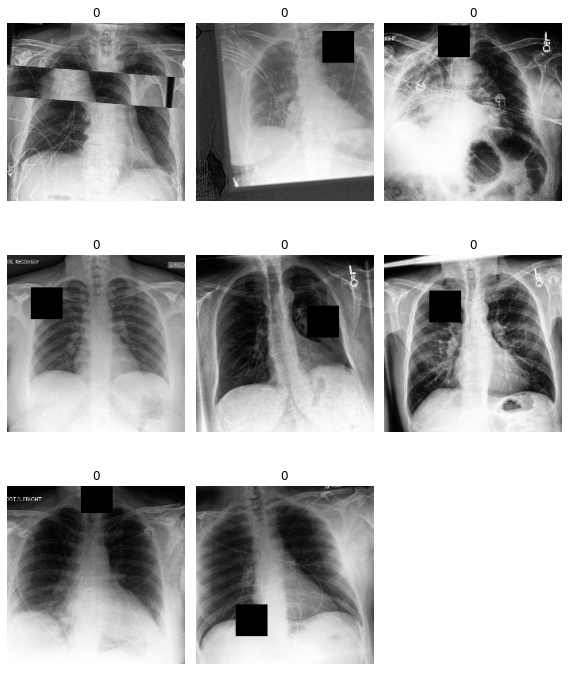

In [ ]:
## to see the images in train with there labels
data.show_batch(rows=3, figsize=(8,10))

In [ ]:
## print the target classes
print(data.classes)

[0, 1]


In [ ]:
learn = cnn_learner(data, models.densenet169, metrics=[error_rate, accuracy], model_dir="/tmp/model/")

Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth


In [ ]:

from fastai import *
from fastai.vision import *
from sklearn.model_selection import StratifiedKFold
from pathlib import Path
import shutil
from sklearn.metrics import f1_score, confusion_matrix

np.random.seed(1786)
ROOT = "/tmp/data0100"

In [ ]:

def read_data(root):
    train_df = pd.read_csv(k)
    test_df = pd.read_csv(p)
    return train_df, test_df

In [ ]:
class SaveBestModel(Recorder):
    def __init__(self, learn,name='best_model'):
        super().__init__(learn)
        self.name = name
        self.best_loss = None
        self.best_acc = None
        self.save_method = self.save_when_acc
        
    def save_when_acc(self, metrics):        
        loss, acc = metrics[0], metrics[1]
        if (self.best_acc is None) or (acc > self.best_acc) or (loss < self.best_loss):
            self.best_acc = acc
            self.best_loss = loss
            self.learn.save(f'{self.name}')
            print("Save the best acc {:.5f}".format(self.best_acc))
        elif acc == self.best_acc and  loss < self.best_loss:
            self.best_loss = loss
            self.learn.save(f'{self.name}')
            print("Acc is eq,Save the lower loss {:.5f}".format(self.best_loss))
            
    def on_epoch_end(self,last_metrics=MetricsList,**kwargs:Any):
        self.save_method(last_metrics)

In [ ]:
#Path(ROOT).mkdir(exist_ok=True, parents=True)
src1 = "/content/content/covid_image_data"
shutil.copytree(src1, ROOT)


if __name__=="__main__":
    train_df, test_df = read_data(ROOT)
    print(train_df.shape, test_df.shape)
    
    cvlist = list(StratifiedKFold(16, random_state=12345786).split(train_df, train_df.label))
    
    tfms1 = get_transforms(max_zoom=1.5)
    test_preds_all = []
    val_preds_all = []
    for i in range(3):
        print("Starting fold {}".format(i))
        tr_idx, val_idx = cvlist[i]
        print(tr_idx.shape, val_idx.shape)
        src = (ImageList.from_df(train_df, path=ROOT, folder="train").split_by_idxs(tr_idx, val_idx)
                                                            .label_from_df())
        data = ImageDataBunch.create_from_ll(src, ds_tfms=tfms1, size=224, bs=32, resize_method=3).normalize(imagenet_stats)
        data.add_test(ImageList.from_df(test_df, path=ROOT, folder="test"))
        learn = cnn_learner(data, models.densenet201, metrics=accuracy, ps=0.5)
        # learn.model[0].load_state_dict(torch.load("../input/save-body-weights-marvel/bestmodel_body.path"))
        cb = SaveBestModel(learn, name="bestmodel_{}".format(i))
        # learn.fit(1, callbacks=cb)
        learn.fit_one_cycle(4)
        learn.unfreeze()
        learn.fit_one_cycle(6, max_lr=1e-4, callbacks=[cb])
        learn.fit_one_cycle(5, max_lr=5e-5, callbacks=[cb])
        #learn.fit_one_cycle(4, max_lr=1e-5, callbacks=[cb])
        #learn.fit_one_cycle(3, max_lr=5e-6, callbacks=[cb])
        learn.fit_one_cycle(2, max_lr=1e-6, callbacks=[cb])
        learn.load("bestmodel_{}".format(i))
        val_preds, y = learn.TTA(ds_type=DatasetType.Valid)
        val_preds = np.exp(val_preds.numpy())
        print("F1 score for this fold ",f1_score(y.numpy(), np.argmax(val_preds,axis=1), average='weighted'))
        test_preds = np.exp(learn.TTA(ds_type=DatasetType.Test)[0].numpy())
        test_preds_all.append(test_preds)
        val_preds_all.append(val_preds)
        fname = "bestmodel_{}.pth".format(i)
        src = str(Path(ROOT) / "models" / fname)
        shutil.copy(src, fname)
    test_preds_all = np.mean(test_preds_all, axis=0)
    val_preds_all = np.concatenate(val_preds_all, axis=0)

    np.save("test_preds.npy", test_preds_all)
    np.save("val_preds.npy", val_preds_all)

(3479, 2) (870, 1)
Starting fold 0
(3261,) (218,)


Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


epoch,train_loss,valid_loss,accuracy,time
0,0.628350,0.177959,0.944954,01:10
1,0.302746,0.113712,0.949541,01:10
2,0.197670,0.188225,0.931193,01:10
3,0.172620,0.135323,0.931193,01:10


epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,0.147967,0.165155,0.935780,01:17
1,0.164431,0.151274,0.944954,01:17
2,0.129972,0.120988,0.963303,01:16
3,0.095377,0.082257,0.972477,01:17
4,0.086095,0.083255,0.963303,01:18
5,0.070116,0.067558,0.958716,01:18


Save the best acc 0.93578
Save the best acc 0.94495
Save the best acc 0.96330
Save the best acc 0.97248
Save the best acc 0.95872


epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,0.051326,0.063638,0.963303,01:18
1,0.072509,0.066184,0.967890,01:18
2,0.061931,0.068879,0.963303,01:18
3,0.054814,0.054727,0.981651,01:17
4,0.041153,0.042929,0.981651,01:16


Save the best acc 0.96330
Save the best acc 0.96789
Save the best acc 0.98165
Save the best acc 0.98165


epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,0.046170,0.044519,0.986239,01:16
1,0.047109,0.045271,0.986239,01:16


Save the best acc 0.98624


F1 score for this fold  0.9813319389646813


Starting fold 1
(3261,) (218,)


epoch,train_loss,valid_loss,accuracy,time
0,0.667014,0.507848,0.853211,01:10
1,0.311189,0.244614,0.940367,01:09
2,0.189264,0.141691,0.944954,01:08
3,0.154373,0.133619,0.949541,01:08


epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,0.123578,0.112742,0.967890,01:15
1,0.163434,0.135138,0.940367,01:14
2,0.136817,0.149125,0.931193,01:14
3,0.104006,0.106161,0.949541,01:15
4,0.083315,0.085025,0.963303,01:14
5,0.064994,0.082270,0.963303,01:14


Save the best acc 0.96789
Save the best acc 0.94954
Save the best acc 0.96330
Save the best acc 0.96330


epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,0.071550,0.079529,0.972477,01:15
1,0.070165,0.083502,0.963303,01:16
2,0.067949,0.107594,0.963303,01:16
3,0.047370,0.082411,0.963303,01:17
4,0.042404,0.092213,0.967890,01:18


Save the best acc 0.97248


epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,0.041337,0.095673,0.963303,01:17
1,0.048882,0.087087,0.967890,01:16


F1 score for this fold  0.9719979084470218


Starting fold 2
(3261,) (218,)


epoch,train_loss,valid_loss,accuracy,time
0,0.670190,0.433805,0.866973,01:13
1,0.301680,0.218261,0.922018,01:12
2,0.191730,0.162148,0.944954,01:12
3,0.147232,0.128071,0.940367,01:11


epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,0.145197,0.145388,0.940367,01:17
1,0.163963,0.161110,0.949541,01:16
2,0.153849,0.180435,0.935780,01:14
3,0.135875,0.111741,0.954128,01:16
4,0.083536,0.085152,0.972477,01:16
5,0.074773,0.082475,0.972477,01:15


Save the best acc 0.94037
Save the best acc 0.94954
Save the best acc 0.95413
Save the best acc 0.97248
Save the best acc 0.97248


epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,0.070779,0.098639,0.958716,01:16
1,0.086344,0.044768,0.986239,01:17
2,0.071190,0.077502,0.963303,01:16
3,0.047444,0.072996,0.967890,01:17
4,0.049711,0.070103,0.972477,01:16


Save the best acc 0.98624


epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,0.047076,0.069404,0.972477,01:15
1,0.044373,0.070947,0.972477,01:16


F1 score for this fold  0.9759916340792846


In [ ]:
x = np.argmax(test_preds, axis=1)
x

array([0, 0, 1, 0, ..., 0, 0, 0, 0])

In [ ]:
submission = pd.DataFrame({
        #"filename":test['filename'],
        "prediction":x
    })
submission.to_csv('./dp_xraysz.csv', index=False)
print(submission)

     prediction
0             0
1             0
2             1
3             0
4             1
..          ...
865           1
866           0
867           0
868           0
869           0

[870 rows x 1 columns]


In [ ]:
from google.colab import files
files.download('dp_xraysz.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>